Для начала сделаем полностью классификацию, а потом регрессию

# Решающее дерево для классификации

## Бейзлайн

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("adult.csv") 

original_rows = len(df)

df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]

print(f"Было строк: {original_rows}")
print(f"Стало строк: {len(df)}")
print(f"Удалено строк: {original_rows - len(df)}")

results_tree = []


Было строк: 32561
Стало строк: 30162
Удалено строк: 2399


/tmp/ipykernel_19115/2818246278.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df[~df.applymap(lambda x: str(x).strip() == '?').any(axis=1)]


In [3]:
# Подготовка признаков

X = df.drop('salary', axis=1)
y = df['salary']

y = y.map({' <=50K': 0, ' >50K': 1})

X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(include=['object'])

label_encoders = {}
X_categorical_encoded = X_categorical.copy()

for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

X_processed = pd.concat([X_numeric, X_categorical_encoded], axis=1)

In [4]:
# Подготавливаем модель и обучаем


X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train, y_train)

# Предсказания
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]

# Метрики
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

results_tree.append({
    "Гипотеза": "Базовая",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})


Accuracy: 0.8106
F1-score: 0.6228
ROC-AUC: 0.7497


Ну результаты в целом похожи на то, что у нас было раньше. Неплохой фундамент для дальнейшей работы Правда ROC-AUC пониже. Теперь буду пытаться улучшить мое решающее дерево. 

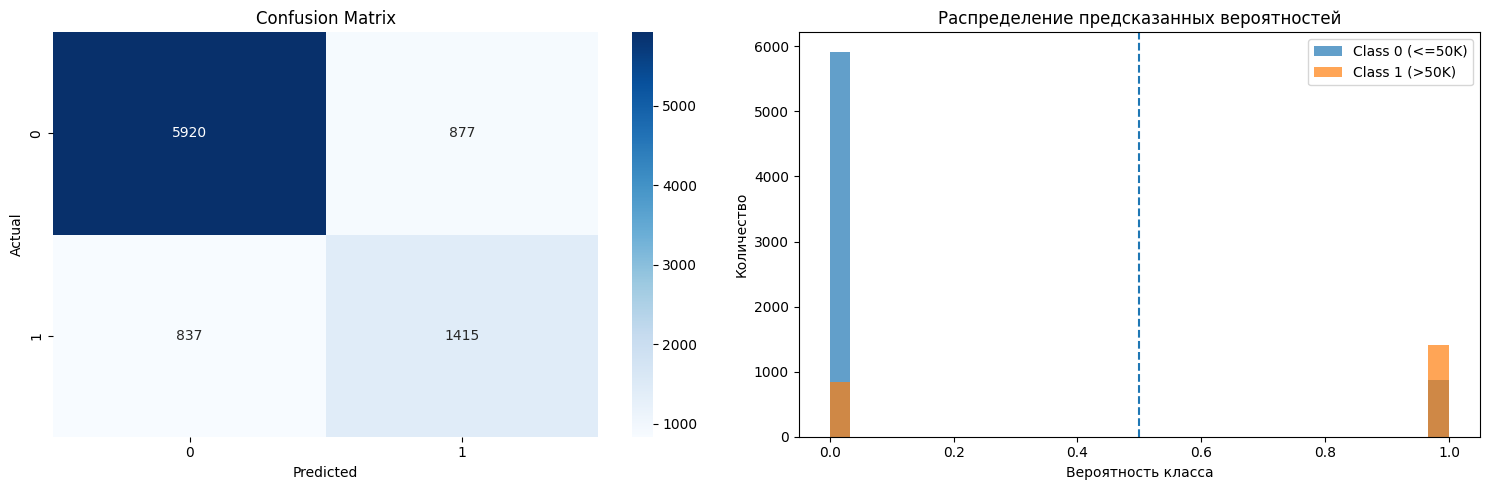

In [5]:
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Распределение вероятностей
axes[1].hist(y_proba[y_test == 0], bins=30, alpha=0.7, label='Class 0 (<=50K)')
axes[1].hist(y_proba[y_test == 1], bins=30, alpha=0.7, label='Class 1 (>50K)')
axes[1].set_title('Распределение предсказанных вероятностей')
axes[1].set_xlabel('Вероятность класса')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].axvline(x=0.5, linestyle='--')

plt.tight_layout()
plt.show()

На графике распределения вероятностей видно два пика около 0 и 1. Это потому, что решающее дерево для каждого листа просто считает, какой класс встречается чаще, и выдаёт вероятность, равную этой доле. Поскольку многие листья содержат мало объектов одного класса, дерево уверено «на 100%» в своём решении. В отличие от логистической регрессии или kNN, дерево не размазывает вероятности, а делает резкие, чёткие предсказания. Так что мой обычный способ для улучшения метрик путем сдвигания порога тут не пройдет.


# Гипотезы

## Гипотеза 1:  подбор гиперпараметров дерева
Оптимизация ключевых параметров дерева позволяет улучшить качество предсказаний за счёт более подходящей структуры и критерия разбиения.

## Гипотеза 2: удаление малоинформативных категориальных признаков
Не все категориальные признаки одинаково полезны. Если оставить признаки с очень большим количеством уникальных значений, дерево будет "разбрасываться" на мелкие разбиения, что снижает обобщающую способность

## Гипотеза 3: target encoding категориальных признаков
Кодирование категориальных признаков через средний доход по категории даёт дереву сильный сигнал о важности категорий и повышает точность предсказаний.

In [6]:
# Гипотеза 1
param_grid = {
    'max_depth': [5, 8, 12, None],
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

scoring_metrics = ['f1', 'accuracy', 'roc_auc']

for metric in scoring_metrics:
    grid = GridSearchCV(
        estimator=DecisionTreeClassifier(random_state=42),
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring=metric
    )

    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    print(f"Лучшие параметры для {metric}:", best_params)

    # Обучаем дерево с лучшими параметрами
    dt_best = DecisionTreeClassifier(random_state=42, **best_params)
    dt_best.fit(X_train, y_train)

    y_pred = dt_best.predict(X_test)
    y_proba = dt_best.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Сохраняем результаты с названием метрики
    results_tree.append({
        "Гипотеза": f"Гипотеза 1 ({metric})",
        "F1": f1,
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc
    })

Лучшие параметры для f1: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшие параметры для accuracy: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 2}
Лучшие параметры для roc_auc: {'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 2}


In [7]:
# Гипотеза 2
X_train_cat = X_train[X_categorical.columns]
X_test_cat = X_test[X_categorical.columns]

# Вычисляем взаимную информацию категориальных признаков с целевой переменной
mi = mutual_info_classif(X_train_cat, y_train, discrete_features=True)

mi_df = pd.DataFrame({
    'feature': X_categorical.columns,
    'mutual_info': mi
})

# Отбираем признаки с информацией с определенным порогом информации
threshold = mi_df['mutual_info'].quantile(0.25)
informative_features = mi_df[mi_df['mutual_info'] >= threshold]['feature'].tolist()

# Формируем новые train/test с только информативными признаками
X_train_filtered = pd.concat([X_train[X_numeric.columns], X_train_cat[informative_features]], axis=1)
X_test_filtered = pd.concat([X_test[X_numeric.columns], X_test_cat[informative_features]], axis=1)

# Обучаем дерево
dt_filtered = DecisionTreeClassifier(random_state=42)
dt_filtered.fit(X_train_filtered, y_train)

# Предсказания
y_pred = dt_filtered.predict(X_test_filtered)
y_proba = dt_filtered.predict_proba(X_test_filtered)[:, 1]

# Метрики
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Сохраняем результаты
results_tree.append({
    "Гипотеза": "Гипотеза 2",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

print("Признаки оставлены для обучения:", informative_features)
print(f"Количество оставленных признаков: {len(informative_features)}")

Признаки оставлены для обучения: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
Количество оставленных признаков: 6


In [8]:
# Гипотеза 3
X_train_te = X_train.copy()
X_test_te = X_test.copy()

for col in X_categorical.columns:
    mapping = y_train.map(lambda x: 1 if x=='>50K' else 0).groupby(X_train[col]).mean()
    X_train_te[col] = X_train[col].map(mapping)
    X_test_te[col] = X_test[col].map(mapping).fillna(mapping.mean())

# Обучаем дерево
dt_te = DecisionTreeClassifier(random_state=42)
dt_te.fit(X_train_te, y_train)

y_pred = dt_te.predict(X_test_te)
y_proba = dt_te.predict_proba(X_test_te)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

results_tree.append({
    "Гипотеза": "Гипотеза 3",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

In [9]:
df_results = pd.DataFrame(results_tree)

print("="*70)
print("Сравнение всех моделей Decision Tree")
print("="*70)
display(df_results.sort_values("F1", ascending=False))



Сравнение всех моделей Decision Tree


,Гипотеза,F1,Accuracy,ROC-AUC
1,Гипотеза 1 (f1),0.680881,0.801525,0.892073
2,Гипотеза 1 (accuracy),0.649935,0.850481,0.899244
3,Гипотеза 1 (roc_auc),0.649935,0.850481,0.899244
4,Гипотеза 2,0.628433,0.813129,0.753570
0,Базовая,0.622799,0.810587,0.749651
5,Гипотеза 3,0.529399,0.762073,0.687307


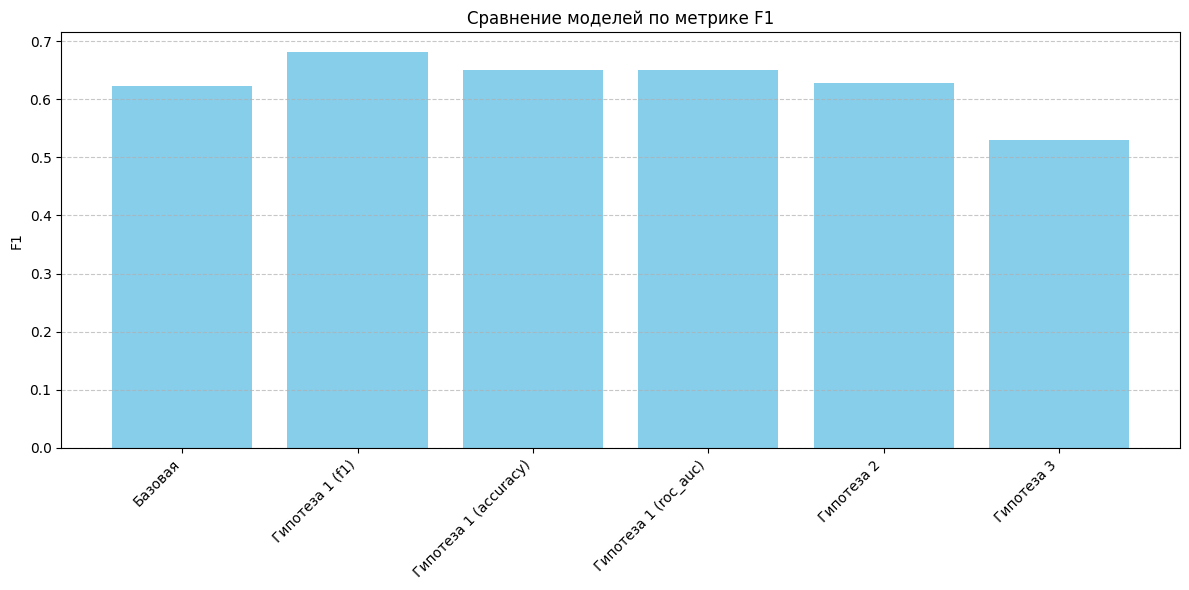

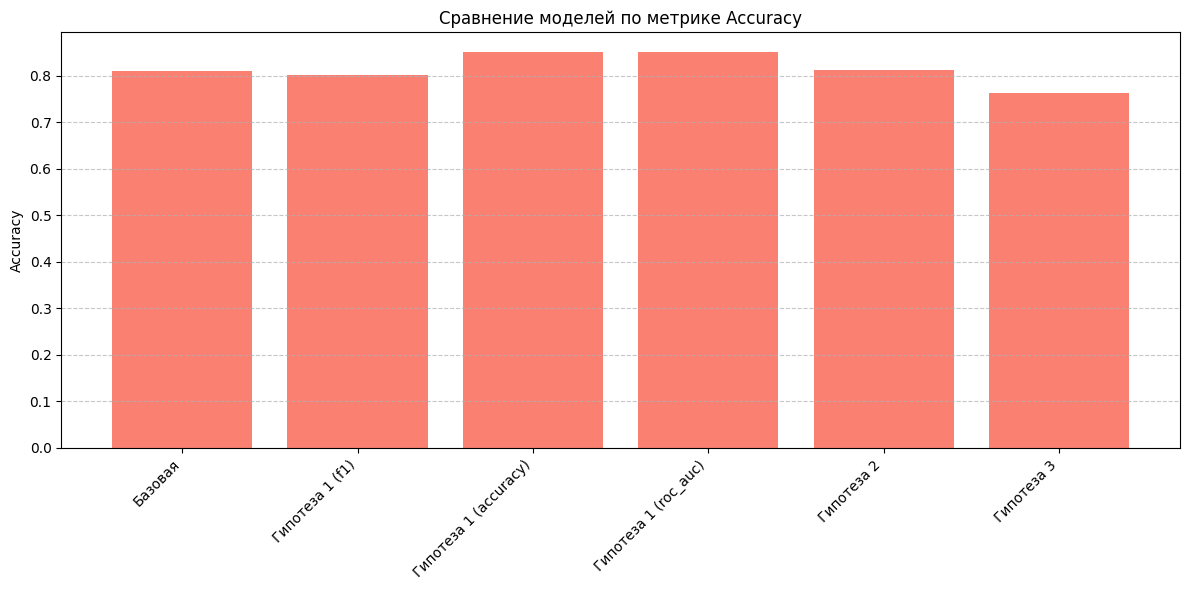

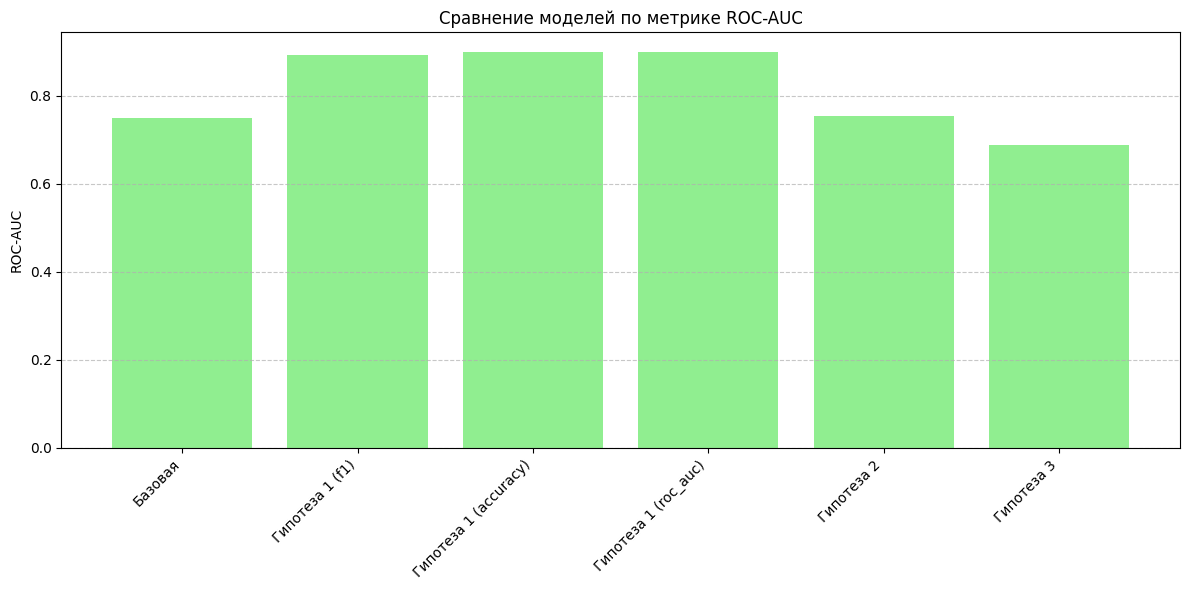

In [10]:
# Графики по метрикам
metrics = ["F1", "Accuracy", "ROC-AUC"]
colors = ["skyblue", "salmon", "lightgreen"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    plt.bar(df_results["Гипотеза"], df_results[metric], color=colors[i])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Сравнение моделей по метрике {metric}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Как мы видим из результатов. Реальный прогресс дал только подбор гиперпараметров. Гипотеза 2 дает совсем незначительную прибавку. Так что о ней нет смысла говорить. При етом я игрался там с тем, какие параметры оставлять и она давала либо небольшой улучшение, либо была хуже бейзлайна. Что касается гипотезы 3, она просто серьезно ухудшает результат. Подбор гиперпараметров показывает как обычно наилучший результат. Если делать его по f1, то f1 будет выше чем в бейзлайне аж на 6%, однако будет немного проседать точность. Так что я думаю идеальный вариант подбирать гиперпараметры по точности или ROC-AUC. В таком случае наша точнсоть будет выше 0,85, что неплохой результат, а f1 так же будет улучшаться по сравнению с бейзлайном на 2 процента. Думаю ето неплохие улучшения. 

## Имплементация решающего дерева для классификации

In [11]:
from collections import Counter

# Собственная реализация решающего дерева
class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.tree = self._build_tree(X, y, depth=0)

    def _gini(self, y):
        counts = np.bincount(y)
        p = counts / len(y)
        return 1 - np.sum(p**2)

    def _best_split(self, X, y):
        m, n = X.shape
        best_gini = 1.0
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                left_mask = X[:, idx] <= thr
                right_mask = ~left_mask
                if sum(left_mask) < 1 or sum(right_mask) < 1:
                    continue
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                gini_total = (sum(left_mask) * gini_left + sum(right_mask) * gini_right) / m
                if gini_total < best_gini:
                    best_gini = gini_total
                    best_idx = idx
                    best_thr = thr
        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        if len(set(y)) == 1:
            return {'type': 'leaf', 'class': y[0]}
        if self.max_depth is not None and depth >= self.max_depth:
            return {'type': 'leaf', 'class': Counter(y).most_common(1)[0][0]}
        if len(y) < self.min_samples_split:
            return {'type': 'leaf', 'class': Counter(y).most_common(1)[0][0]}

        idx, thr = self._best_split(X, y)
        if idx is None:
            return {'type': 'leaf', 'class': Counter(y).most_common(1)[0][0]}

        left_mask = X[:, idx] <= thr
        right_mask = ~left_mask

        left_branch = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_branch = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'type': 'node', 'feature_idx': idx, 'threshold': thr,
                'left': left_branch, 'right': right_branch}

    def _predict_one(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        if x[node['feature_idx']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

# Подготовка данных для имплементации
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Создаём и обучаем дерево
my_tree = MyDecisionTree(max_depth=5)
my_tree.fit(X_train_np, y_train_np)

# Предсказания
y_pred = my_tree.predict(X_test_np)

# Метрики
accuracy = accuracy_score(y_test_np, y_pred)
f1 = f1_score(y_test_np, y_pred)
roc_auc = roc_auc_score(y_test_np, y_pred)  

# Сохраняем результаты
results_tree.append({
    "Гипотеза": "Имплементированное дерево (базовое)",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

# Вывод метрик
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8490
F1-score: 0.6409
ROC-AUC: 0.7462


Изначально показаны неплохие результаты. Ну уровне с подобранными гиперпараметрами. Теперь попробуем взять лучшие гиперпараметры по ROC-AUC из проверки гипотез и запустить модель с ними. Хотя из-за отсутствия поддержки criterion и class_weight результат вряд ли сильно улучшится.

In [12]:
best_params = {
    'max_depth': 8,
    'min_samples_split': 2,
    'min_samples_leaf': 20
    # 'criterion' и 'class_weight' игнорируем, так как в нашей имплементации нет их поддержки
}

# Создаём и обучаем дерево с лучшими параметрами
my_tree_best = MyDecisionTree(max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'])

my_tree_best.fit(X_train_np, y_train_np)

# Предсказания
y_pred_best = my_tree_best.predict(X_test_np)

# Метрики
accuracy = accuracy_score(y_test_np, y_pred_best)
f1 = f1_score(y_test_np, y_pred_best)
roc_auc = roc_auc_score(y_test_np, y_pred_best)  # бинарные предсказания

# Сохраняем результаты
results_tree.append({
    "Гипотеза": "Имплементированное дерево с улучшением",
    "F1": f1,
    "Accuracy": accuracy,
    "ROC-AUC": roc_auc
})

# Вывод метрик
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8498
F1-score: 0.6482
ROC-AUC: 0.7516


In [13]:
df_results = pd.DataFrame(results_tree)

print("="*70)
print("Сравнение всех моделей Decision Tree")
print("="*70)
display(df_results.sort_values("F1", ascending=False))

Сравнение всех моделей Decision Tree


,Гипотеза,F1,Accuracy,ROC-AUC
1,Гипотеза 1 (f1),0.680881,0.801525,0.892073
2,Гипотеза 1 (accuracy),0.649935,0.850481,0.899244
3,Гипотеза 1 (roc_auc),0.649935,0.850481,0.899244
7,Имплементированное дерево с улучшением,0.648201,0.849818,0.751566
6,Имплементированное дерево (базовое),0.640904,0.849044,0.746152
4,Гипотеза 2,0.628433,0.813129,0.753570
0,Базовая,0.622799,0.810587,0.749651
5,Гипотеза 3,0.529399,0.762073,0.687307


Как мы видимо подбор гиперпараметров практически ничего не дал, улучшение лишь небольшое. Ето связано с тем, что у меня нет поддержки criterion и class_weight и из-за етого по сути изменение гиперпараметров практически ничего не дает.

# Регрессия

## Безлайн решающего дерева для регрессии

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Загружаем датасет
df = pd.read_csv("diamonds.csv")

# Разделяем признаки и целевую переменную
X = df.drop('price', axis=1)
y = df['price']

# Разделяем на числовые и категориальные признаки
X_numeric = X.select_dtypes(include=[np.number])
X_categorical = X.select_dtypes(include=['object'])

# Кодируем категориальные признаки
X_categorical_encoded = X_categorical.copy()
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Объединяем признаки
X_processed = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42
)

# Обучаем дерево регрессии
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)

# Предсказания
y_pred = dt_reg.predict(X_test)

# Метрики
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Сохраняем результаты (список для регрессии, аналогично results_tree)
results_tree_reg = []
results_tree_reg.append({
    "Гипотеза": "Базовое дерево регрессии",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

# Выводим метрики
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


R2: 0.9999
RMSE: 47.7565
MAE: 3.1533


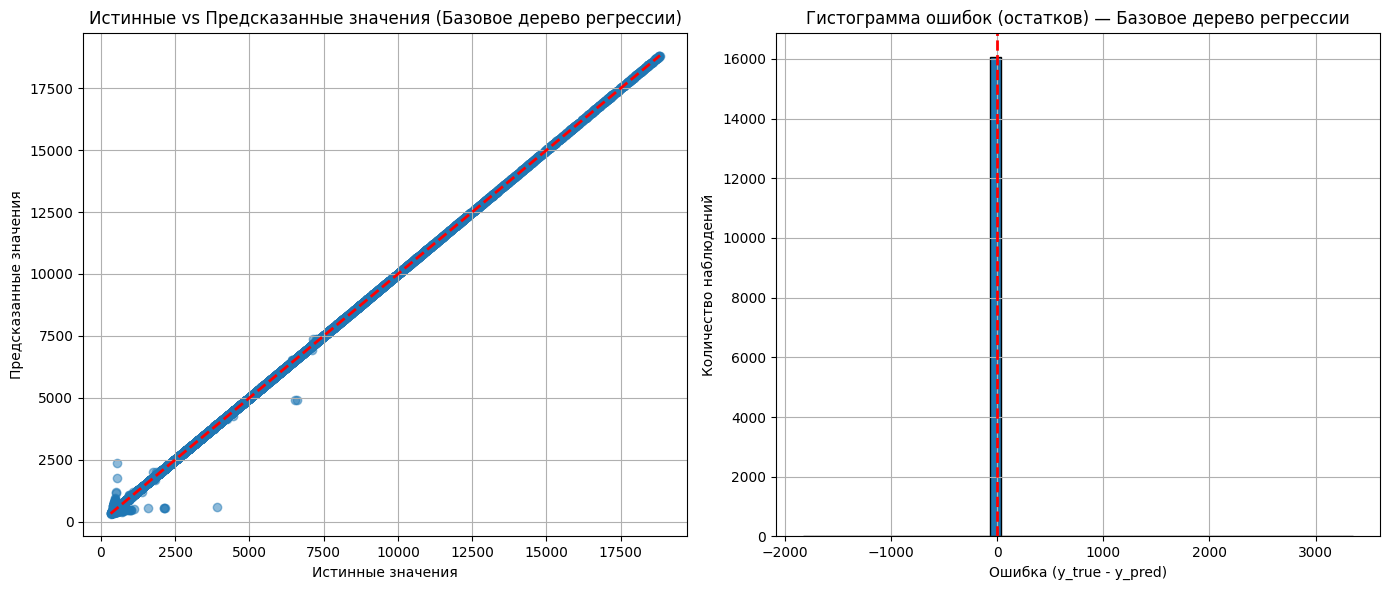

In [15]:
# Рассчитаем остатки
residuals_baseline = y_test - y_pred

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Истинные vs Предсказанные значения (Базовое дерево регрессии)')
plt.grid(True)

# 2. Гистограмма ошибок
plt.subplot(1, 2, 2)
plt.hist(residuals_baseline, bins=50, edgecolor='black')
plt.title("Гистограмма ошибок (остатков) — Базовое дерево регрессии")
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True)

plt.tight_layout()
plt.show()

Что ж. Как видно и из результатов метрик и из графиков модель научилась слишком идеально предсказывать результаты. Думаю в данном случае мы можем говорить о переобучении и наши гипотезы должны быть напрвалены на то, чтобы немного снизить показатели метрик.

# Формулирование гипотез

## Гипотеза 1: ограничение глубины дерева и минимального числа образцов в листе

## Гипотеза 2: усреднение через случайный отбор признаков

## Гипотеза 3: преобразование признаков через нормализацию или стандартизацию

In [16]:
# Гипотеза 1
dt_reg_hyp1 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=100, random_state=42)
dt_reg_hyp1.fit(X_train, y_train)

y_pred_hyp1 = dt_reg_hyp1.predict(X_test)

r2 = r2_score(y_test, y_pred_hyp1)
rmse = mean_squared_error(y_test, y_pred_hyp1, squared=False)
mae = mean_absolute_error(y_test, y_pred_hyp1)

results_tree_reg.append({
    "Гипотеза": "Гипотеза 1",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})


In [17]:
# Гипотеза 2
dt_reg_hyp2 = DecisionTreeRegressor(max_features="sqrt", random_state=42)
dt_reg_hyp2.fit(X_train, y_train)

y_pred_hyp2 = dt_reg_hyp2.predict(X_test)

r2 = r2_score(y_test, y_pred_hyp2)
rmse = mean_squared_error(y_test, y_pred_hyp2, squared=False)
mae = mean_absolute_error(y_test, y_pred_hyp2)

results_tree_reg.append({
    "Гипотеза": "Гипотеза 2",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})


In [18]:
# Гипотеза 3
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[X_numeric.columns] = scaler.fit_transform(X_train[X_numeric.columns])
X_test_scaled[X_numeric.columns] = scaler.transform(X_test[X_numeric.columns])

dt_reg_hyp3 = DecisionTreeRegressor(random_state=42)
dt_reg_hyp3.fit(X_train_scaled, y_train)

y_pred_hyp3 = dt_reg_hyp3.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred_hyp3)
rmse = mean_squared_error(y_test, y_pred_hyp3, squared=False)
mae = mean_absolute_error(y_test, y_pred_hyp3)

results_tree_reg.append({
    "Гипотеза": "Гипотеза 3",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})


In [19]:
df_results = pd.DataFrame(results_tree_reg)

print("="*70)
print("Сравнение всех моделей Decision Tree Regressor")
print("="*70)
display(df_results.sort_values("R2", ascending=False))


Сравнение всех моделей Decision Tree Regressor


,Гипотеза,R2,RMSE,MAE
3,Гипотеза 3,0.999854,47.656800,3.132493
0,Базовое дерево регрессии,0.999854,47.756456,3.153319
2,Гипотеза 2,0.993418,320.404493,108.245334
1,Гипотеза 1,0.987645,438.971316,199.319092


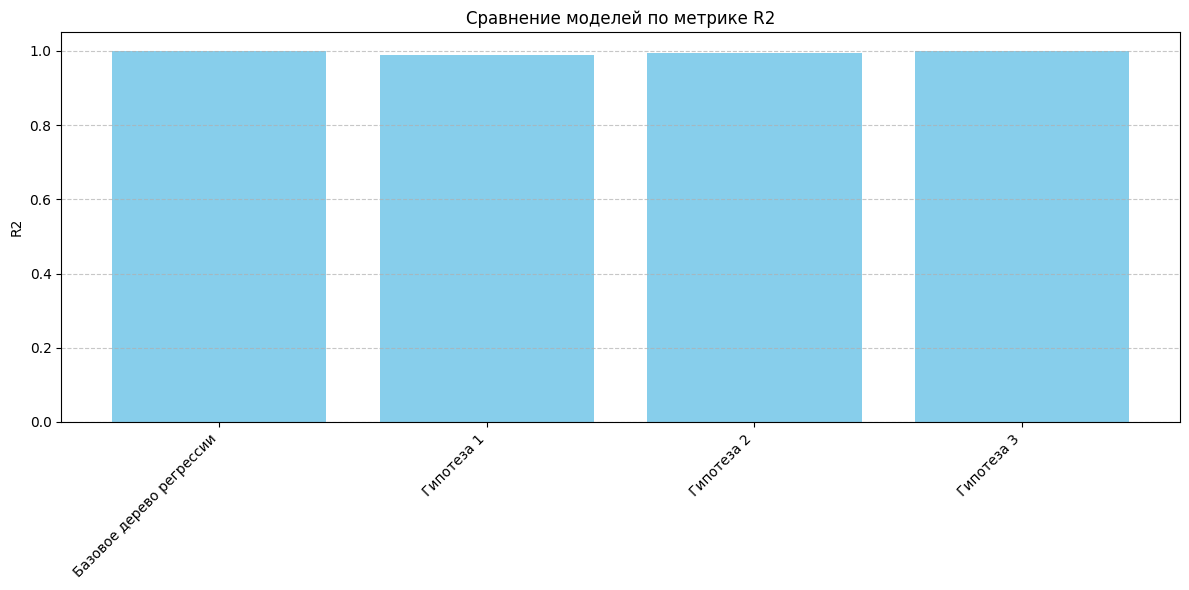

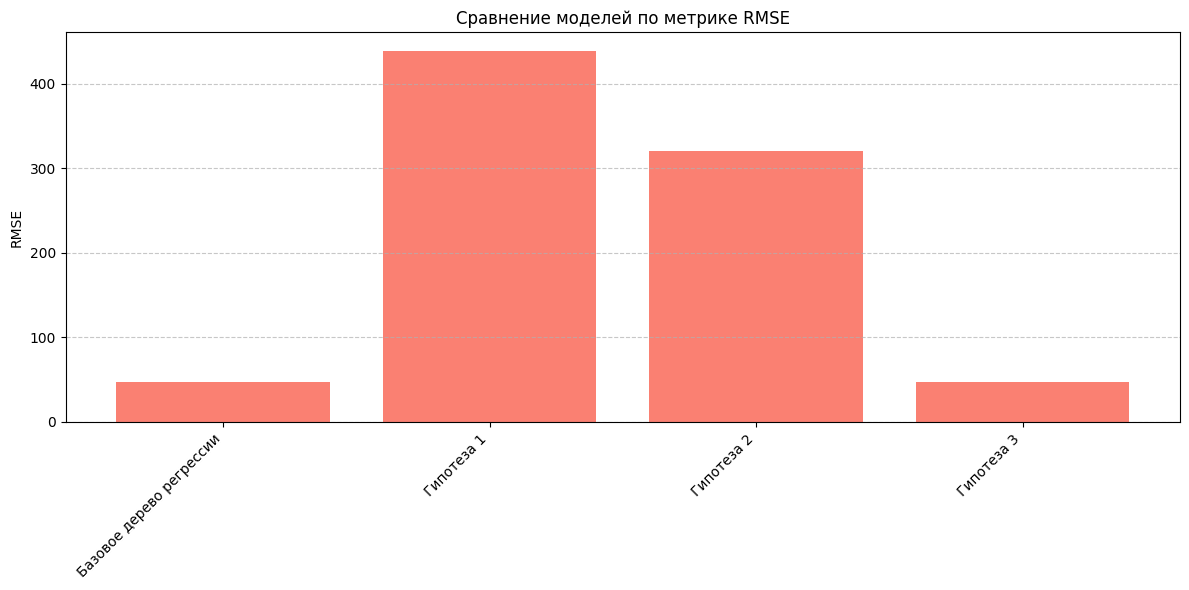

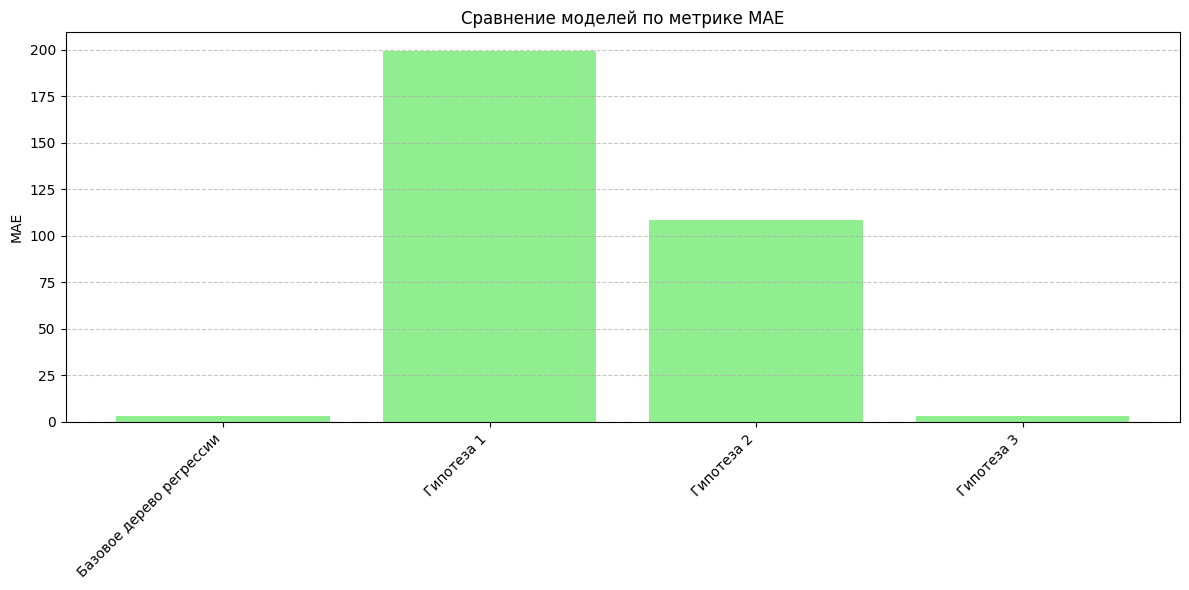

In [20]:
# Графики по метрикам
metrics = ["R2", "RMSE", "MAE"]
colors = ["skyblue", "salmon", "lightgreen"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    plt.bar(df_results["Гипотеза"], df_results[metric], color=colors[i])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Сравнение моделей по метрике {metric}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Что ж, попытки исправить переобучения успехом особо не увенчались. R2 остается огромным. При етом портятся другие метрики. Возможно я был не прав и переобучения нет вообще. Сейчас проверим ето с помощью кросс-валидации.

R2 по фолдам кросс-валидации: [0.99996497 0.99984559 0.99991897 0.99993625 0.99984112]
Среднее R2: 0.9999013806008248


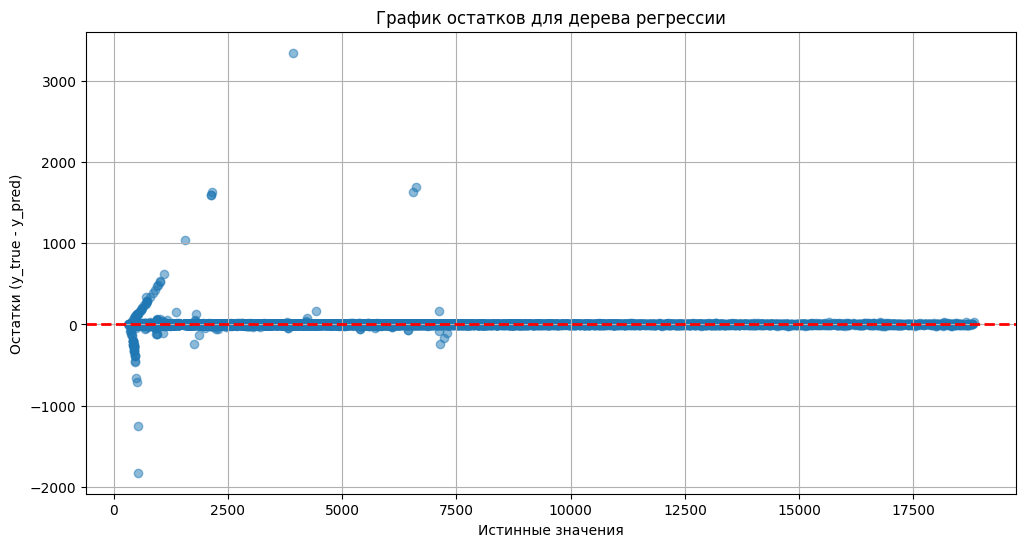

In [21]:
# Проверим переобучается ли модель или нет

from sklearn.model_selection import KFold, cross_val_score


# Создаём дерево регрессии с базовыми параметрами
dt_cv = DecisionTreeRegressor(random_state=42)

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(dt_cv, X_processed, y, cv=kf, scoring='r2')
print("R2 по фолдам кросс-валидации:", r2_scores)
print("Среднее R2:", r2_scores.mean())

# Обучаем дерево на всей тренировочной выборке
dt_cv.fit(X_train, y_train)
y_pred_test = dt_cv.predict(X_test)

# Остатки
residuals = y_test - y_pred_test

# График остатков
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Истинные значения")
plt.ylabel("Остатки (y_true - y_pred)")
plt.title("График остатков для дерева регрессии")
plt.grid(True)
plt.show()


Что ж, результаты показывают, что видимо я был не прав. Модель не переобучена, потому что она стабильно показывает высокие показатели на всех частях данных. R2 по кросс-валидации почти такой же, как на тренировочном наборе, что говорит о том, что дерево не «запомнило» конкретные примеры, а действительно умеет обобщать закономерности. Ошибки на тесте также невелики, и остатки распределены равномерно, без резких выбросов, что подтверждает корректность предсказаний. В целом, модель хорошо подходит для этой задачи и справляется с новыми данными. Так же не вижу смысла сейчас писать отдельно улучшенный бейзлайн, потому что обычное решающее дерево уже идеально предсказывает цену.

# Имплементация решающего дерева для регрессии

In [22]:

class MyDecisionTreeRegressorFast:
    def __init__(self, max_depth=None, min_samples_split=2, n_thresholds=10):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_thresholds = n_thresholds
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _mse(self, y):
        return np.var(y) if len(y) > 0 else 0.0

    def _best_split(self, X, y):
        m, n = X.shape
        best_mse = float('inf')
        best_idx, best_thr = None, None

        for idx in range(n):
            col = X[:, idx]
            # выбираем n_thresholds кандидатов порога
            thresholds = np.unique(np.percentile(col, np.linspace(0, 100, self.n_thresholds)))
            for thr in thresholds:
                left_mask = col <= thr
                right_mask = ~left_mask
                if sum(left_mask) < 1 or sum(right_mask) < 1:
                    continue
                mse_total = (sum(left_mask) * self._mse(y[left_mask]) +
                             sum(right_mask) * self._mse(y[right_mask])) / m
                if mse_total < best_mse:
                    best_mse = mse_total
                    best_idx = idx
                    best_thr = thr
        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        if len(y) < self.min_samples_split:
            return {'type': 'leaf', 'value': np.mean(y)}
        if self.max_depth is not None and depth >= self.max_depth:
            return {'type': 'leaf', 'value': np.mean(y)}

        idx, thr = self._best_split(X, y)
        if idx is None:
            return {'type': 'leaf', 'value': np.mean(y)}

        left_mask = X[:, idx] <= thr
        right_mask = ~left_mask

        left_branch = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_branch = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'type': 'node', 'feature_idx': idx, 'threshold': thr,
                'left': left_branch, 'right': right_branch}

    def _predict_one(self, x, node):
        if node['type'] == 'leaf':
            return node['value']
        if x[node['feature_idx']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

# Подготовка данных
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Создаём и обучаем дерево
my_tree_reg_fast = MyDecisionTreeRegressorFast(max_depth=8, min_samples_split=20, n_thresholds=20)
my_tree_reg_fast.fit(X_train_np, y_train_np)

# Предсказания
y_pred = my_tree_reg_fast.predict(X_test_np)

# Метрики
r2 = r2_score(y_test_np, y_pred)
rmse = mean_squared_error(y_test_np, y_pred, squared=False)
mae = mean_absolute_error(y_test_np, y_pred)

# Сохраняем результаты
results_tree_reg.append({
    "Гипотеза": "Имплементированное дерево",
    "R2": r2,
    "RMSE": rmse,
    "MAE": mae
})

print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R2: 0.9941
RMSE: 303.5261
MAE: 61.4706


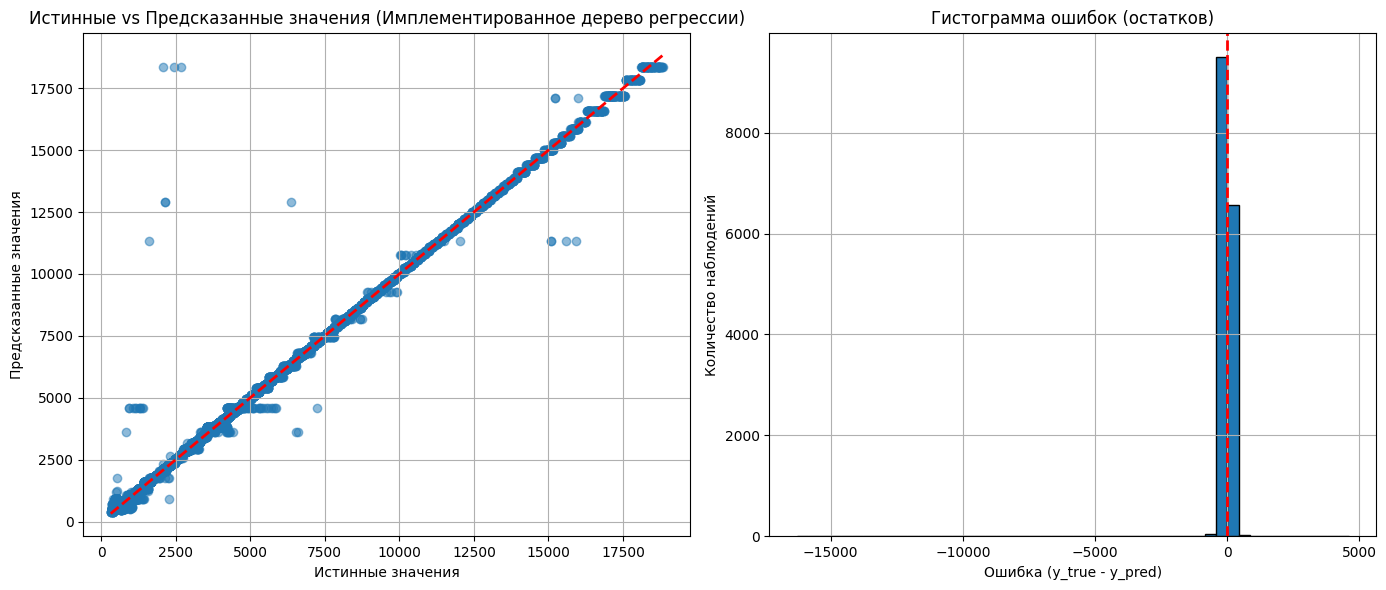

In [23]:
# Остатки
residuals = y_test_np - y_pred

plt.figure(figsize=(14, 6))

# 1. Истинные vs Предсказанные
plt.subplot(1, 2, 1)
plt.scatter(y_test_np, y_pred, alpha=0.5)
plt.plot(
    [y_test_np.min(), y_test_np.max()],
    [y_test_np.min(), y_test_np.max()],
    'r--',
    lw=2
)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Истинные vs Предсказанные значения (Имплементированное дерево регрессии)")
plt.grid(True)

# 2. Гистограмма остатков
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.axvline(0, linestyle='--', color='red', lw=2)
plt.xlabel("Ошибка (y_true - y_pred)")
plt.ylabel("Количество наблюдений")
plt.title("Гистограмма ошибок (остатков)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [24]:
df_results = pd.DataFrame(results_tree_reg)

print("="*70)
print("Сравнение всех моделей Decision Tree Regressor")
print("="*70)
display(df_results.sort_values("R2", ascending=False))

Сравнение всех моделей Decision Tree Regressor


,Гипотеза,R2,RMSE,MAE
3,Гипотеза 3,0.999854,47.656800,3.132493
0,Базовое дерево регрессии,0.999854,47.756456,3.153319
4,Имплементированное дерево,0.994093,303.526144,61.470578
2,Гипотеза 2,0.993418,320.404493,108.245334
1,Гипотеза 1,0.987645,438.971316,199.319092


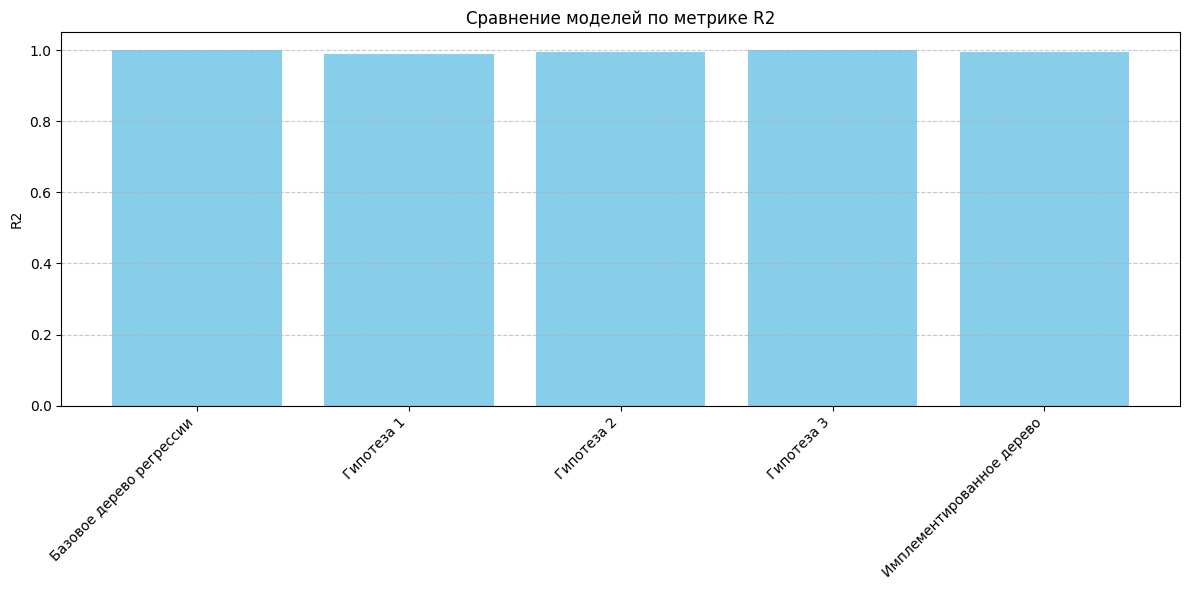

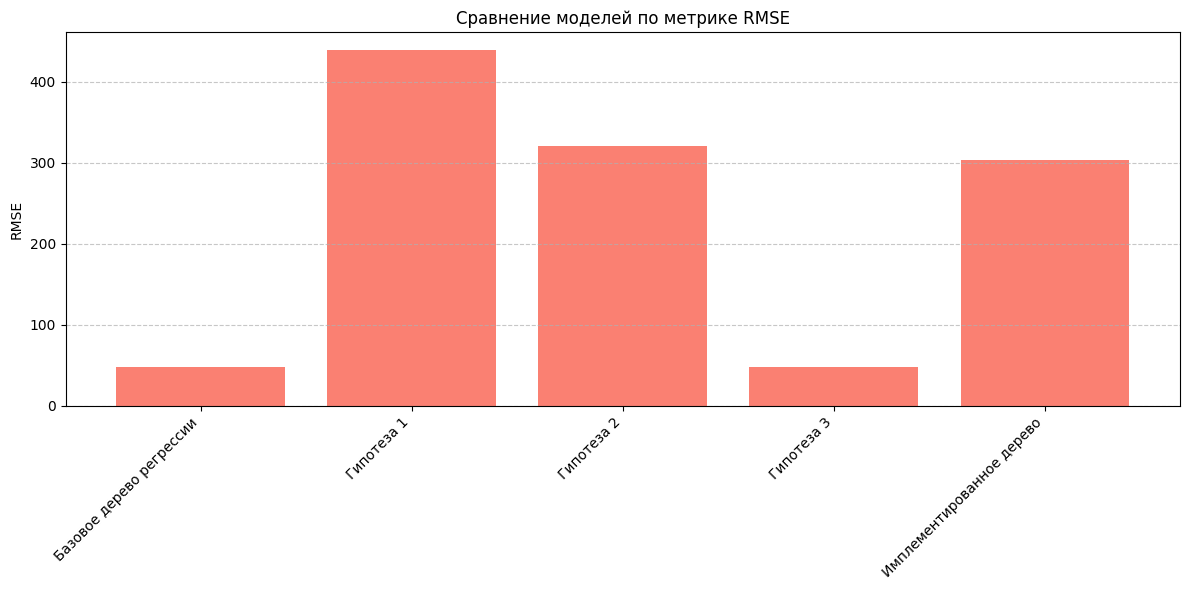

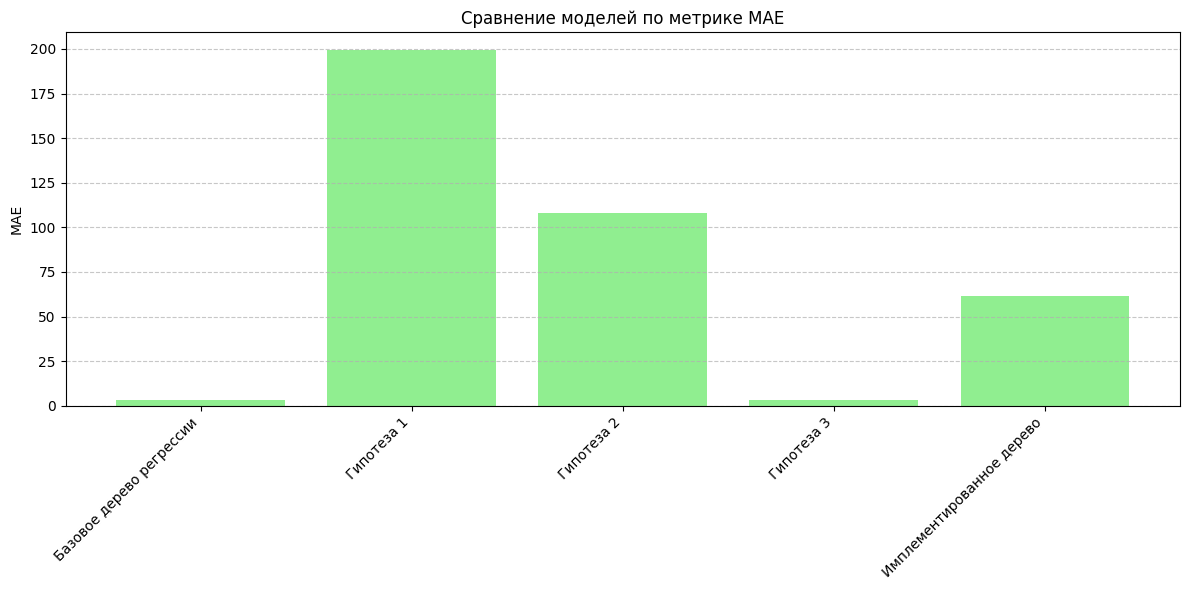

In [25]:
# Графики по метрикам
metrics = ["R2", "RMSE", "MAE"]
colors = ["skyblue", "salmon", "lightgreen"]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(12, 6))
    plt.bar(df_results["Гипотеза"], df_results[metric], color=colors[i])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Сравнение моделей по метрике {metric}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Что ж, как видно из результатов имплементированное дерево показывает результаты хуже бейзлайна, однако результаты все еще отличные. Несмотря на то, что ошибки по сравнению с бейзланом больше в несколько раз, результат все еще хороший. Как можно заметить по графику имплементированного дерева регрессии, повышенные значения метрик связаны с некоторыми максимально абсурдными предсказаниями, которое сильно выбиываются. Делай улучшенные бейзлайн для имплементации смысла я не вижу. Его особо не улучшить. Все мои гипотезы были направлены на ухудшение результатов, на борьбу с переобучением, которого по итогу не оказалось. А улучшить результаты имплементации будет сложно. Она в целом отлично предсказывает результаты, но есть некоторые "выбросы", которое связаны с особенностью реализации моего алгоритма.